In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=589b3228af3ef8b0ea93342aef7517241a34a9fb925c2eb78bfaf41173cfd12d
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy, pandas, matplotlib.pyplot, seaborn
from sklearn import decomposition, preprocessing, feature_selection, linear_model
import datetime

import matplotlib
font = {'weight' : 'bold','size'   : 17}
matplotlib.rc('font', **font)

from google.colab import drive 
drive.mount('/content/drive')
import os

from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import NaiveBayes, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Mounted at /content/drive


## Load Data

In [3]:
def sparkload():
  spark = SparkSession.builder.getOrCreate()
  driveloc='/content/drive/MyDrive/Big_Data'
  path=os.path.join(driveloc,'Hotel Reservations.csv')
  hrdt=spark.read.option("header",True) \
      .csv(path)
  hrdt.show()
  return hrdt, spark

In [4]:
HRdata,spark=sparkload()
HRdata.printSchema()

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+--

## Data Information and Analysis

### Feature Information

In [5]:
def datadetails(hr):
  hrd=hr.toPandas()
  print("Feature Details\n")
  print(hrd.info())
  print("Missing Values\n")
  print(hrd.isna().sum())

In [6]:
datadetails(HRdata)

Feature Details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Booking_ID                            36275 non-null  object
 1   no_of_adults                          36275 non-null  object
 2   no_of_children                        36275 non-null  object
 3   no_of_weekend_nights                  36275 non-null  object
 4   no_of_week_nights                     36275 non-null  object
 5   type_of_meal_plan                     36275 non-null  object
 6   required_car_parking_space            36275 non-null  object
 7   room_type_reserved                    36275 non-null  object
 8   lead_time                             36275 non-null  object
 9   arrival_year                          36275 non-null  object
 10  arrival_month                         36275 non-null  object
 11  arrival_dat

### Data Formatting

In [7]:
def dataformatting(hr):
  hrd=hr.toPandas()
  hrd=hrd.drop('Booking_ID',axis=1)
  coltonum=['no_of_adults','no_of_children','no_of_weekend_nights','no_of_week_nights','required_car_parking_space',
            'lead_time','arrival_month','arrival_date','repeated_guest','no_of_previous_cancellations',
            'no_of_previous_bookings_not_canceled','avg_price_per_room','no_of_special_requests']
  for col in coltonum:
    hrd[col]=numpy.array(hrd[col],float)
  hrd1=hrd.copy()
  hrd1['booking_status']=hrd1['booking_status'].replace(hrd1['booking_status'].unique(),[b for b in range(len(hrd1['booking_status'].unique()))])
  hrdbg=spark.createDataFrame(hrd)
  hrd1bg=spark.createDataFrame(hrd1)
  return hrdbg, hrd1bg, hrd


In [8]:
HRdataFrmtd,HRdataAn,HRpnds= dataformatting(HRdata)

In [9]:
HRdataFrmtd.show()

+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------

In [10]:
HRdataAn.show()

+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------

In [11]:
HRpnds.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2.0,0.0,1.0,2.0,Meal Plan 1,0.0,Room_Type 1,224.0,2017,10.0,2.0,Offline,0.0,0.0,0.0,65.00,0.0,Not_Canceled
1,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


## Data Visualization

In [12]:
def catviz(hr,ft):
  if "_" in ft:
    fts=ft.split("_")
    for f in range(len(fts)):
      fts[f]=fts[f].capitalize()
    fts=' '.join(fts)
  clschm=["#0000A0","#08A04B","#006A4E","#FFFF00","#16F529","#EB5406","#DC143C"]
  pandas.crosstab(hr['booking_status'],hr[ft]).plot(kind='bar',figsize=(9,5),fontsize=20, color=clschm[:len(hr[ft].unique())])
  matplotlib.pyplot.title("Booking Status for {}".format(fts))
  matplotlib.pyplot.xlabel('Booking Status',fontsize=17, color="b")
  matplotlib.pyplot.ylabel('{}'.format(fts),fontsize=17, color="b")
  matplotlib.pyplot.grid()
  matplotlib.pyplot.show()

In [13]:
def numviz(hr,ft):
  if "_" in ft:
    fts=ft.split("_")
    for f in range(len(fts)):
      fts[f]=fts[f].capitalize()
    fts=' '.join(fts)
  hrcn=hr[hr['booking_status']=='Canceled']
  hrncn=hr[hr['booking_status']=='Not_Canceled']
  mn1=hrcn[ft].mean()
  mn2=hrncn[ft].mean()
  matplotlib.pyplot.title("Booking Status for \nAverage {}".format(fts),fontsize=20, color="b")
  matplotlib.pyplot.barh(['Canceled','Not_Canceled'],[mn1,mn2],alpha=0.7,color=["#EB5406","#16F529"])
  matplotlib.pyplot.ylabel('Booking Status',fontsize=17, color="b")
  matplotlib.pyplot.xlabel('{}'.format(fts),fontsize=17, color="b")
  matplotlib.pyplot.grid()
  matplotlib.pyplot.show()

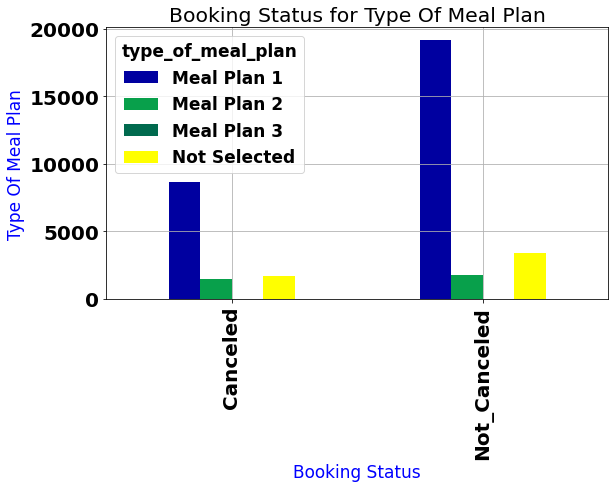

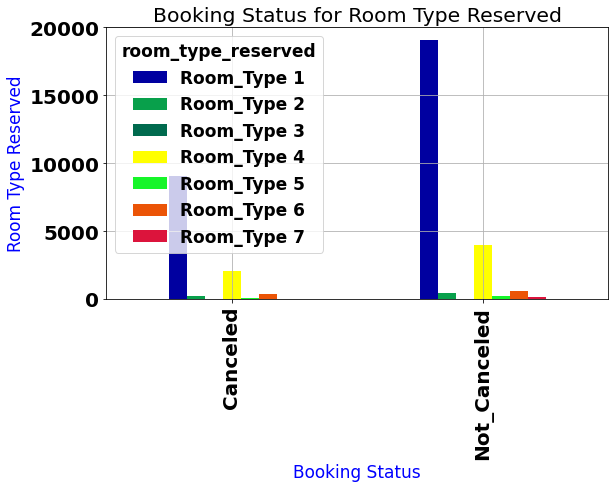

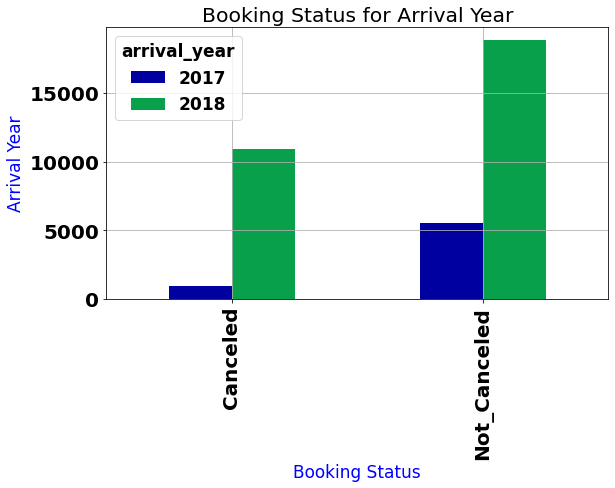

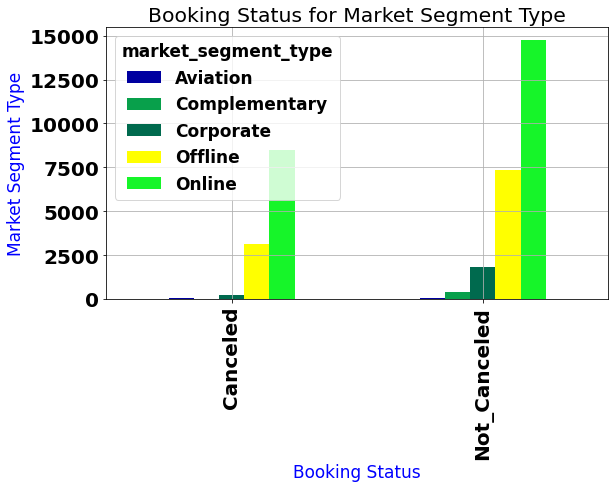

In [14]:
col_obj=HRpnds.dtypes[HRpnds.dtypes=='object'].index.tolist()[:-1]
col_numr=HRpnds.dtypes[HRpnds.dtypes=='float64'].index.tolist()
for co in col_obj:
  catviz(HRpnds,co)

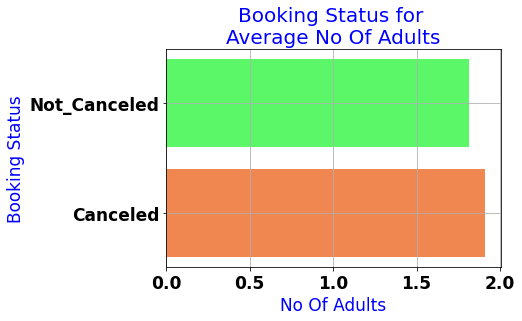

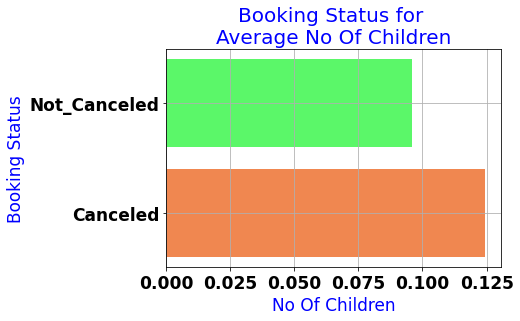

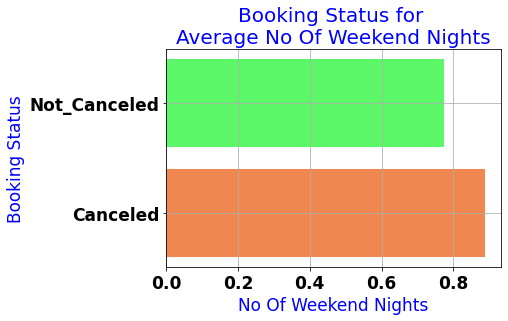

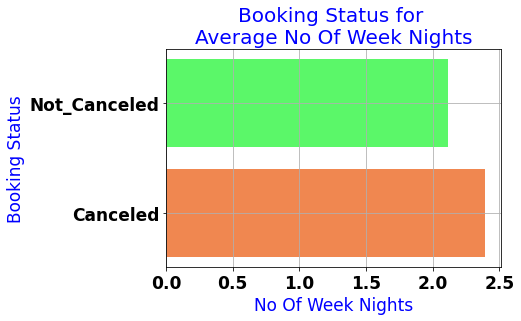

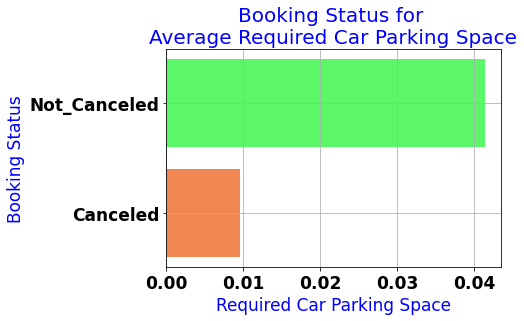

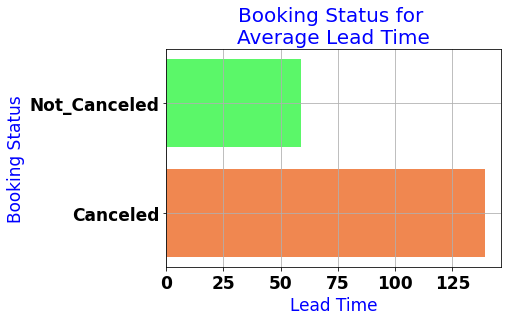

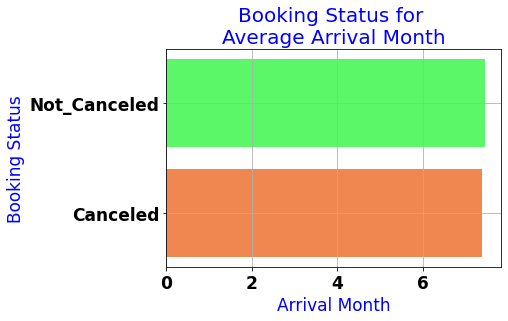

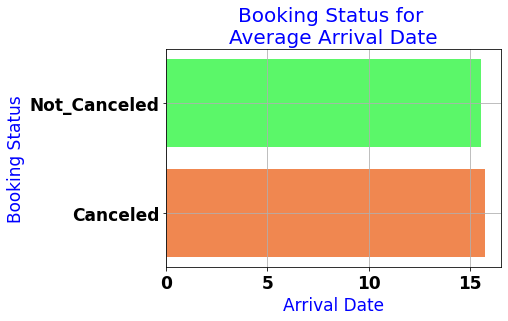

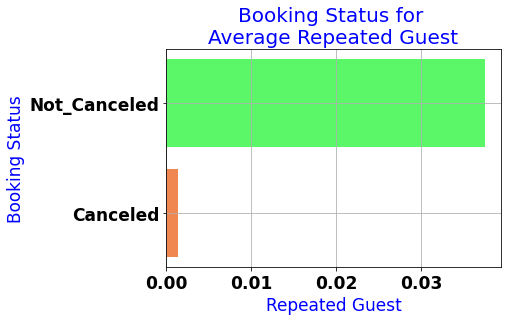

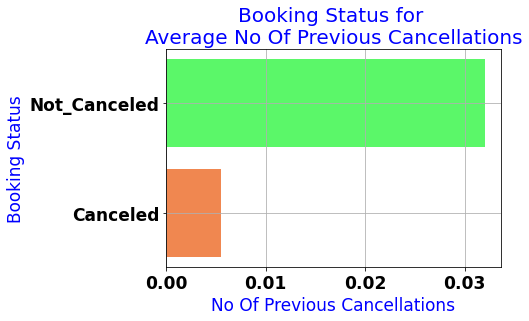

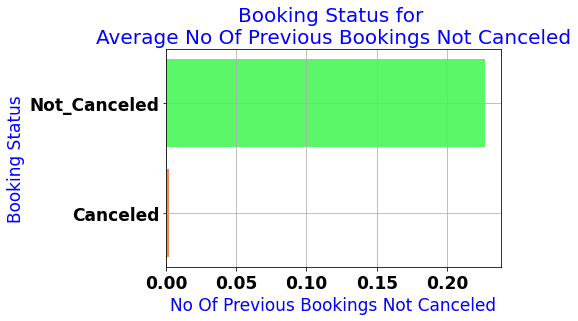

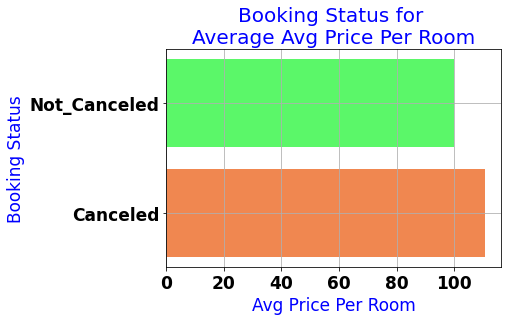

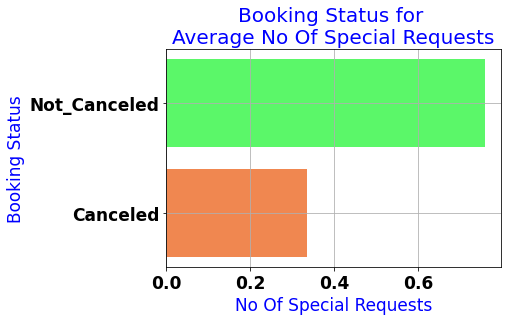

In [15]:
for cn in col_numr:
  numviz(HRpnds,cn)

## Data Preprocessing

## Feature Encoding

In [16]:
def fetenc(hr):
  hr1=hr.copy()
  col_obj=hr1.dtypes[hr1.dtypes=='object'].index.tolist()[:-1]
  col_numr=hr1.dtypes[hr1.dtypes=='float64'].index.tolist() 
  le=preprocessing.LabelEncoder()
  hr1[col_obj] = hr1[col_obj].apply(le.fit_transform)
  return hr1

In [17]:
HRdataEnc=fetenc(HRpnds)
HRdataEnc.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2.0,0.0,1.0,2.0,0,0.0,0,224.0,0,10.0,2.0,3,0.0,0.0,0.0,65.00,0.0,Not_Canceled
1,2.0,0.0,2.0,3.0,3,0.0,0,5.0,1,11.0,6.0,4,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,1.0,0.0,2.0,1.0,0,0.0,0,1.0,1,2.0,28.0,4,0.0,0.0,0.0,60.00,0.0,Canceled
3,2.0,0.0,0.0,2.0,0,0.0,0,211.0,1,5.0,20.0,4,0.0,0.0,0.0,100.00,0.0,Canceled
4,2.0,0.0,1.0,1.0,3,0.0,0,48.0,1,4.0,11.0,4,0.0,0.0,0.0,94.50,0.0,Canceled


### Outlier Treatement

In [18]:
def chk_outliers(hr,cmp,w,h,col):
    arrhr=numpy.array(hr.iloc[:,:-1])
    pca_model = decomposition.PCA(n_components=cmp)
    pca_model.fit(arrhr)
    print(pca_model.explained_variance_ratio_)
    components=["Comp-{}".format(x+1) for x in range(len(pca_model.explained_variance_ratio_.tolist()))]
    matplotlib.pyplot.figure(figsize=(w,h))
    matplotlib.pyplot.title("PCA Variance({} Components)(Max: {})".format(cmp,"%.2f" %pca_model.explained_variance_ratio_.max()),fontsize=18)
    matplotlib.pyplot.bar(components,pca_model.explained_variance_ratio_.tolist(),alpha=0.7,width=0.5,color=col)
    matplotlib.pyplot.xlabel("PCA",fontsize=14)
    matplotlib.pyplot.xticks(rotation=90)
    matplotlib.pyplot.ylabel("Variance",fontsize=14)
    matplotlib.pyplot.grid()
    matplotlib.pyplot.show()
    return pca_model.explained_variance_ratio_

In [19]:
def normalize_data(hr):
    ppmmx = preprocessing.MinMaxScaler()
    nrm_hr=ppmmx.fit_transform(hr)
    return nrm_hr

[0.84834164 0.14075253]


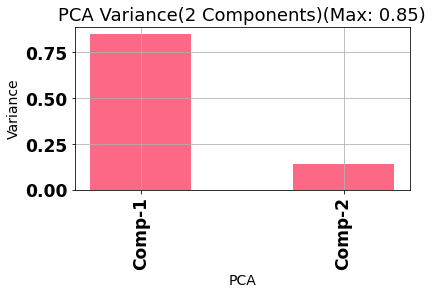

[0.84834164 0.14075253 0.00876891]


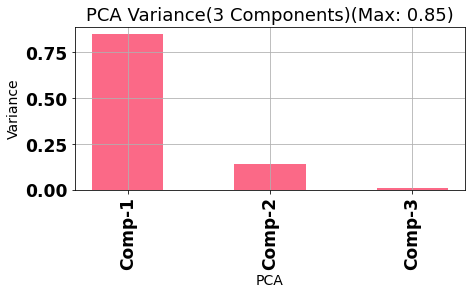

[0.84834164 0.14075253 0.00876891 0.00105751]


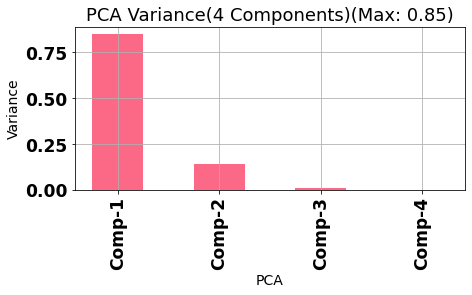

[8.48341638e-01 1.40752532e-01 8.76891031e-03 1.05751270e-03
 3.54480447e-04]


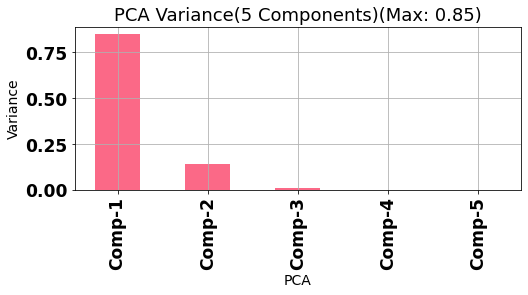

[8.48341638e-01 1.40752532e-01 8.76891031e-03 1.05751270e-03
 3.54480447e-04 2.41339858e-04]


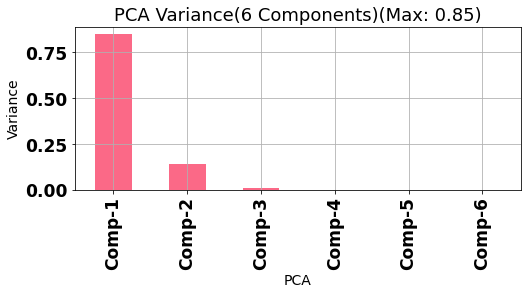

[8.48341638e-01 1.40752532e-01 8.76891031e-03 1.05751270e-03
 3.54480447e-04 2.41339858e-04 1.75671071e-04]


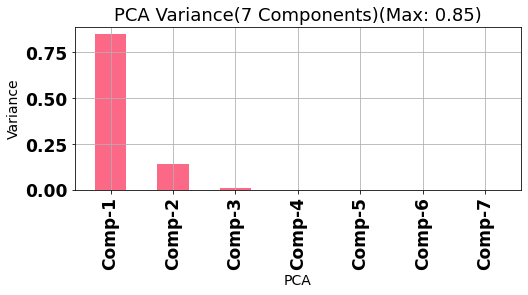

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0.50,0.0,0.142857,0.117647,0.000000,0.0,0.0,0.505643,0.0,0.818182,0.033333,0.75,0.0,0.0,0.0,0.120370,0.0,Not_Canceled
1,0.50,0.0,0.285714,0.176471,1.000000,0.0,0.0,0.011287,1.0,0.909091,0.166667,1.00,0.0,0.0,0.0,0.197556,0.2,Not_Canceled
2,0.25,0.0,0.285714,0.058824,0.000000,0.0,0.0,0.002257,1.0,0.090909,0.900000,1.00,0.0,0.0,0.0,0.111111,0.0,Canceled
3,0.50,0.0,0.000000,0.117647,0.000000,0.0,0.0,0.476298,1.0,0.363636,0.633333,1.00,0.0,0.0,0.0,0.185185,0.0,Canceled
4,0.50,0.0,0.142857,0.058824,1.000000,0.0,0.0,0.108352,1.0,0.272727,0.333333,1.00,0.0,0.0,0.0,0.175000,0.0,Canceled
5,0.50,0.0,0.000000,0.117647,0.333333,0.0,0.0,0.781038,1.0,0.727273,0.400000,1.00,0.0,0.0,0.0,0.212963,0.2,Canceled
6,0.50,0.0,0.142857,0.176471,0.000000,0.0,0.0,0.076749,0.0,0.818182,0.466667,1.00,0.0,0.0,0.0,0.199167,0.2,Not_Canceled
7,0.50,0.0,0.142857,0.176471,0.000000,0.0,0.5,0.187359,1.0,1.000000,0.833333,1.00,0.0,0.0,0.0,0.195574,0.2,Not_Canceled
8,0.75,0.0,0.000000,0.235294,0.000000,0.0,0.0,0.273138,1.0,0.545455,0.166667,0.75,0.0,0.0,0.0,0.179444,0.2,Not_Canceled
9,0.50,0.0,0.000000,0.294118,0.000000,0.0,0.5,0.099323,1.0,0.818182,0.566667,1.00,0.0,0.0,0.0,0.247111,0.6,Not_Canceled


In [20]:
outlier_results=[]
colr='#FA2A55'
outlier_results.append(chk_outliers(HRdataEnc.drop('booking_status',axis=1),2,6,3,colr))
outlier_results.append(chk_outliers(HRdataEnc.drop('booking_status',axis=1),3,7,3,colr))
outlier_results.append(chk_outliers(HRdataEnc.drop('booking_status',axis=1),4,7,3,colr))
outlier_results.append(chk_outliers(HRdataEnc.drop('booking_status',axis=1),5,8,3,colr))
outlier_results.append(chk_outliers(HRdataEnc.drop('booking_status',axis=1),6,8,3,colr))
outlier_results.append(chk_outliers(HRdataEnc.drop('booking_status',axis=1),7,8,3,colr))

outcmmt=[]
out_flg=[]
for ors in outlier_results:
    for r in ors:
        if r>0.8:
            out_flg.append(True)
if len(out_flg)==len(outlier_results) and True in out_flg:
    NormHRdat=normalize_data(HRdataEnc.drop('booking_status',axis=1))
NormHRdata=pandas.DataFrame(NormHRdat,columns=HRdataEnc.drop('booking_status',axis=1).columns.tolist())
NormHRdata['booking_status']=HRdataEnc['booking_status']
NormHRdata.head(10)

[0.25438538 0.19327774]


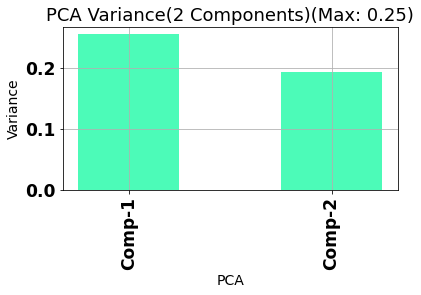

array([0.25438538, 0.19327774])

In [21]:
chk_outliers(NormHRdata.drop('booking_status',axis=1),2,6,3,"#00FA9A")

### Selecting Important Features

In [22]:
def fetengg(sp, hr):
    XHR=hr.drop(['booking_status'],axis=1)
    YHR=hr['booking_status']
    
    mdl_fetsel=feature_selection.SelectKBest(feature_selection.chi2, k=10)
    mdl_fetsel.fit(XHR, YHR)
    print("Selected Features: \n",*XHR.columns[mdl_fetsel.get_support()],sep="\n")
    hrfsel=hr[XHR.columns[mdl_fetsel.get_support()]]
    hrfsel['booking_status']=hr['booking_status']
    hrfsel1=hrfsel.copy()
    hrfsel1['booking_status']=hrfsel1['booking_status'].replace(hrfsel1['booking_status'].unique(),[b for b in range(len(hrfsel1['booking_status'].unique()))])
    hrfselsprk=spark.createDataFrame(hrfsel1)
    return hrfsel, hrfsel1, hrfselsprk

In [23]:
HRdataFin,HRdataen, BGHRdata=fetengg(spark, NormHRdata)
BGHRdata.show()

Selected Features: 

no_of_weekend_nights
type_of_meal_plan
required_car_parking_space
lead_time
arrival_year
market_segment_type
repeated_guest
no_of_previous_cancellations
no_of_previous_bookings_not_canceled
no_of_special_requests
+--------------------+------------------+--------------------------+--------------------+------------+-------------------+--------------+----------------------------+------------------------------------+----------------------+--------------+
|no_of_weekend_nights| type_of_meal_plan|required_car_parking_space|           lead_time|arrival_year|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|no_of_special_requests|booking_status|
+--------------------+------------------+--------------------------+--------------------+------------+-------------------+--------------+----------------------------+------------------------------------+----------------------+--------------+
| 0.14285714285714285|               0.0

In [24]:
HRdataen['booking_status'].unique()

array([0, 1])

### Preparation of Data

In [25]:
def prepdata(bhd, trr):
  tsr=1-trr
  dtfts = [col for col in bhd.columns]
  dtvect = VectorAssembler(inputCols = dtfts, outputCol="features")
  dtvect.transform(bhd).select("features", "booking_status").limit(10).toPandas() 
  Trn, Tst = bhd.randomSplit(weights=[trr, tsr], seed = 100)
  print(Tst.toPandas()['booking_status'].value_counts())
  return dtvect, Trn, Tst

In [26]:
Vect, Train, Test=prepdata(BGHRdata, 0.75)
Vect.transform(BGHRdata).select("features", "booking_status").limit(10).toPandas()

0    6055
1    2947
Name: booking_status, dtype: int64


,features,booking_status
0,"(0.14285714285714285, 0.0, 0.0, 0.505643340857...",0
1,"(0.2857142857142857, 1.0, 0.0, 0.0112866817155...",0
2,"(0.2857142857142857, 0.0, 0.0, 0.0022573363431...",1
3,"(0.0, 0.0, 0.0, 0.47629796839729116, 1.0, 1.0,...",1
4,"(0.14285714285714285, 1.0, 0.0, 0.108352144469...",1
5,"(0.0, 0.3333333333333333, 0.0, 0.7810383747178...",1
6,"(0.14285714285714285, 0.0, 0.0, 0.076749435665...",0
7,"(0.14285714285714285, 0.0, 0.0, 0.187358916478...",0
8,"(0.0, 0.0, 0.0, 0.27313769751693, 1.0, 0.75, 0...",0
9,"(0.0, 0.0, 0.0, 0.09932279909706546, 1.0, 1.0,...",0


## Prediction

### Create Evaluate Model and Pipeline Functions

In [27]:
def modelcreate(trg):
  mets=["accuracy","f1"]
  mdls=[]
  for m in range(len(mets)):
    mdls.append(MulticlassClassificationEvaluator(labelCol=trg, predictionCol="prediction", metricName=mets[m]))
  return mdls

In [28]:
def createpip(vc,dttr,md):
  pl = Pipeline()
  pl.setStages([vc, md])
  mdl_ready = pl.fit(dttr)
  return mdl_ready

### Intiate Models

In [29]:
clfs=[
    NaiveBayes(featuresCol="features",labelCol="booking_status",smoothing=0.0001, modelType="gaussian"),
    LogisticRegression(featuresCol="features",labelCol="booking_status",maxIter=1, regParam=0.1, elasticNetParam=0.3),
    LinearSVC(featuresCol="features",labelCol="booking_status",maxIter=1, regParam=0.01)
]

### Applying Model to Predict

In [30]:
names=["Naive Bayes","Logistic Regression","Linear SVC"]
metall=[[],[],[],[],[],[]]
print("=======================================================")
for cf in range(len(clfs)):
  print("Executing: {}".format(names[cf]))
  t1 = datetime.datetime.now() 
  model=createpip(Vect, Train, clfs[cf])
  t2 = datetime.datetime.now()
  delta = t2 - t1
  print("\nTraining Time: ",delta.total_seconds(),"Seconds")

  t3 = datetime.datetime.now()
  acceval, f1eval=modelcreate("booking_status")  
  acc_training = acceval.evaluate(model.transform(Train))
  acc_test = acceval.evaluate(model.transform(Test))
  f1tr = f1eval.evaluate(model.transform(Train))
  f1ts = f1eval.evaluate(model.transform(Test))
  t4 = datetime.datetime.now()
  delta1 = t4 - t3
  print("\nTest Time: ",delta1.total_seconds(),"Seconds")
  
  print("\nTraining Accuracy: {}\nTest Accuracy: {}\nTraining F1-Score: {}\nTest F1-Score: {}\n".format(acc_training,acc_test,f1tr,f1ts))
  print("--------------------------------------------------------")
  
  print("=======================================================")
  metall[0].append(acc_training)
  metall[1].append(acc_test)
  metall[2].append(f1tr)
  metall[3].append(f1ts)
  metall[4].append(delta.total_seconds())
  metall[5].append(delta1.total_seconds())

Executing: Naive Bayes

Training Time:  2.532849 Seconds

Test Time:  3.883347 Seconds

Training Accuracy: 1.0
Test Accuracy: 1.0
Training F1-Score: 1.0
Test F1-Score: 1.0

--------------------------------------------------------
Executing: Logistic Regression

Training Time:  2.331932 Seconds

Test Time:  2.955161 Seconds

Training Accuracy: 0.6722766105672277
Test Accuracy: 0.6726283048211509
Training F1-Score: 0.5405276115922698
Test F1-Score: 0.5409795292145936

--------------------------------------------------------
Executing: Linear SVC

Training Time:  2.268318 Seconds

Test Time:  1.990726 Seconds

Training Accuracy: 0.9889267773988927
Test Accuracy: 0.9898911353032659
Training F1-Score: 0.9889710286302772
Test F1-Score: 0.9899289008610442

--------------------------------------------------------


### Evaluate

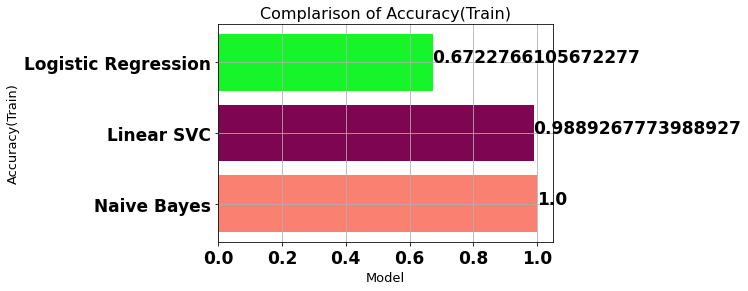

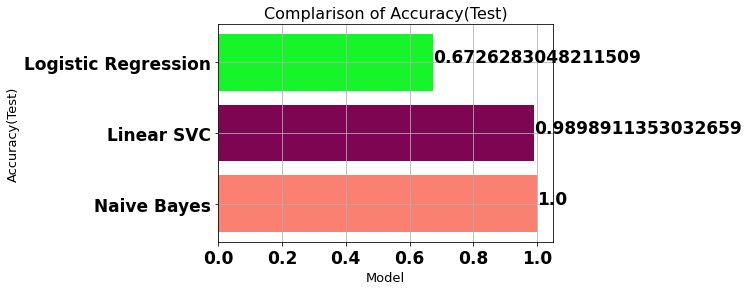

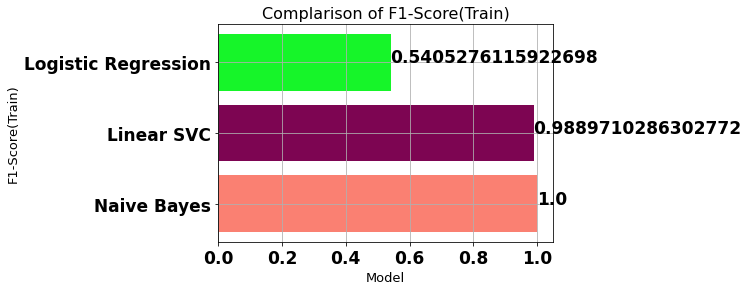

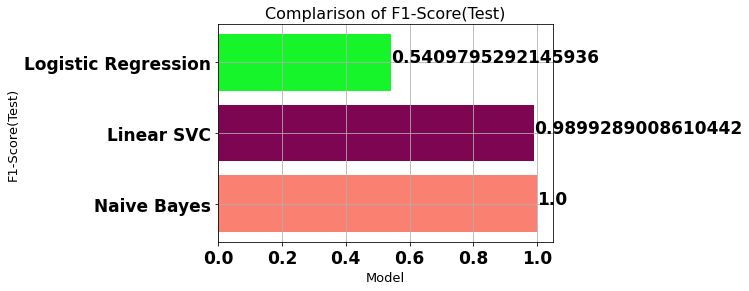

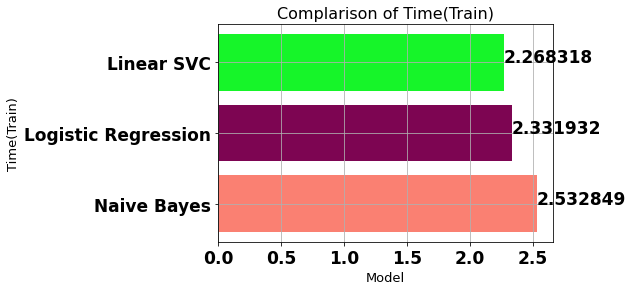

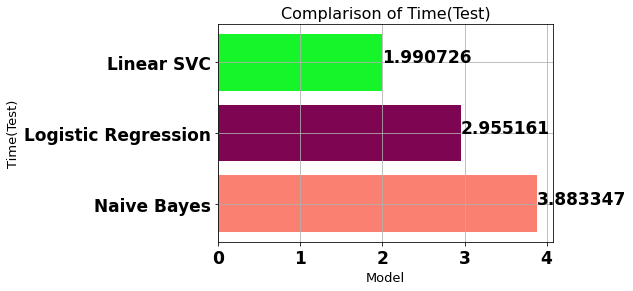

,Model,Accuracy(Train),Accuracy(Test),F1-Score(Train),F1-Score(Test),Time(Train),Time(Test)
0,Naive Bayes,1.000000,1.000000,1.000000,1.000000,2.532849,3.883347
2,Linear SVC,0.988927,0.989891,0.988971,0.989929,2.268318,1.990726
1,Logistic Regression,0.672277,0.672628,0.540528,0.540980,2.331932,2.955161


In [31]:
pred_df=pandas.DataFrame({
    "Model":names,
    "Accuracy(Train)":metall[0],
    "Accuracy(Test)":metall[1],
    "F1-Score(Train)":metall[2],
    "F1-Score(Test)":metall[3],
    "Time(Train)":metall[4],
    "Time(Test)":metall[5]
})
colsdt=pred_df.columns.tolist()[1:]
for cl in colsdt:
    pred_df=pred_df.sort_values(by=cl,ascending=False)
    matplotlib.pyplot.figure(figsize=(6,4))
    matplotlib.pyplot.title("Complarison of {}".format(cl),fontsize=16)
    matplotlib.pyplot.barh(pred_df['Model'],pred_df[cl],color=["#FA8072","#7D0552","#16F529"])
    matplotlib.pyplot.xlabel("Model",fontsize=13)
    matplotlib.pyplot.ylabel("{}".format(cl),fontsize=13)
    for dtix, vlsdt in enumerate(pred_df[cl]):
        matplotlib.pyplot.text(vlsdt, dtix, str(vlsdt))
    matplotlib.pyplot.grid()
    matplotlib.pyplot.show()
pred_df.sort_values(by='Accuracy(Test)',ascending=False).to_csv("Metrics.csv")
pred_df.sort_values(by='Accuracy(Test)',ascending=False)